### 양자화 및 모듈 불러오기

In [24]:
import os
import json
from transformers import AutoModelForCausalLM,AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from peft import get_peft_model,LoraConfig,TaskType
from datasets import load_dataset,Dataset,concatenate_datasets,DatasetDict, load_metric
import torch
from torch.nn.utils.rnn import pad_sequence
from itertools import chain
from functools import partial
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from bert_score import score
import pandas as pd
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Gpu 연결 확인

In [3]:
if torch.cuda.is_available():
    print("GPU를 사용할 수 있습니다.")
    print(f"사용 가능한 GPU 수: {torch.cuda.device_count()}")
    print(f"현재 사용 중인 GPU: {torch.cuda.current_device()}")
    print(f"GPU 이름: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("GPU를 사용할 수 없습니다.")

GPU를 사용할 수 있습니다.
사용 가능한 GPU 수: 8
현재 사용 중인 GPU: 0
GPU 이름: NVIDIA A100-SXM4-80GB


### 모델 불러오기

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  # Set the GPUs 2 and 3 to use

In [8]:
device = torch.device(f'cuda:{0}')

model_id = 'MLP-KTLim/llama-3-Korean-Bllossom-8B'  #'Alphacode-AI/AlphaMist7B-slr-v4-slow2' #'rtzr/ko-gemma-2-9b-it'
base_model = AutoModelForCausalLM.from_pretrained(model_id)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

lora_config = LoraConfig(
     task_type=TaskType.CAUSAL_LM,
     r=1,
     target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'],
     lora_alpha=2,
     lora_dropout=0.05,
)

model = get_peft_model(base_model, lora_config).to(device)
print('Count of using GPUs:', torch.cuda.device_count()) 
model.device

Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


Count of using GPUs: 1


device(type='cuda', index=0)

#데이터 전처리

In [22]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

file_path = '/home/data/dataset/apply_preprocessed_text.txt' #'/home/data/universe_corpus_cleaned.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

sentences = sent_tokenize(text)

def remove_extra_spaces(text):
    return ' '.join(text.split())

data_dict = {'text': [remove_extra_spaces(sentence.strip()) for sentence in sentences if sentence.strip()]}
dataset = Dataset.from_dict(data_dict)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
dataset['text'][2]

'다.본 교범은 정상 및 비정상적인 조건하에서 구난전차를 운용하거나 동력발생 장치, 포탑 등의 중량물 인양 또는 주력전차 및 각종 차량 구난 시 승무원들의 임무수행에 필요한 사항과 구난전차를 정상적인 상태로 장기간 사용하기 위한 각종 점검사항과 정비지침 등을 수록하였다.'

In [24]:
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map: 100%|██████████| 135/135 [00:00<00:00, 3711.34 examples/s]


In [25]:
remainder = {"input_ids": [], "attention_mask": []}

def chunk(sample, chunk_length=2048):
    global remainder
    concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
    concatenated_examples = {k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()}
    batch_total_length = len(concatenated_examples[list(sample.keys())[0]])

    if batch_total_length >= chunk_length:
        batch_chunk_length = (batch_total_length // chunk_length) * chunk_length
        result = {
            k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)]
            for k, t in concatenated_examples.items()
        }
        remainder = {k: concatenated_examples[k][batch_chunk_length:] for k in concatenated_examples.keys()}
        result["labels"] = result["input_ids"].copy()
        return result

    return {"input_ids": [], "attention_mask": [], "labels": []}

In [26]:
chunked_train_dataset = tokenized_train_dataset.map(
    partial(chunk, chunk_length=1024),
    batched=True,
)

chunked_eval_dataset = tokenized_eval_dataset.map(
    partial(chunk, chunk_length=1024),
    batched=True,
)

chunked_train_dataset = chunked_train_dataset.filter(lambda x: len(x['input_ids']) > 0)
chunked_eval_dataset = chunked_eval_dataset.filter(lambda x: len(x['input_ids']) > 0)

Filter: 100%|██████████| 67/67 [00:00<00:00, 753.44 examples/s]


### 모델 학습

In [9]:
model.print_trainable_parameters()

trainable params: 2,621,440 || all params: 7,244,353,536 || trainable%: 0.0362


In [14]:
import wandb

wandb.login(key="YOUR_KEY")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenize

True

In [15]:
import wandb
wandb.init(project='현대차 프로젝트')

# 실행 이름 설정
wandb.run.name = 'continue_train_ko-llama 8B_정비메뉴얼'
wandb.run.save()

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [28]:
training_args = TrainingArguments(
    output_dir='/root/lab_lm/result',
    num_train_epochs=3,
    #fp16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    save_strategy='steps',
    evaluation_strategy='steps',
    save_steps=500,  # Specify how often to save the model
    eval_steps=300,  # Specify how often to evaluate the model
    save_total_limit=1,
    optim='adamw_bnb_8bit',
    save_only_model=True,
    logging_strategy='steps',
    logging_steps=30,
    label_names=['labels'],
    remove_unused_columns=True,
    report_to="wandb",  # Enable logging to W&B
)

/root/lab_lm/lib/python3.8/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=chunked_train_dataset,
    eval_dataset=chunked_eval_dataset,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
300,0.175900,0.374463
600,0.198900,0.219732


TrainOutput(global_step=804, training_loss=0.7606842986386807, metrics={'train_runtime': 1727.749, 'train_samples_per_second': 0.465, 'train_steps_per_second': 0.465, 'total_flos': 3.708559610295091e+16, 'train_loss': 0.7606842986386807, 'epoch': 3.0})

In [17]:
prompt = "Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요?"
inputs = tokenizer(prompt, return_tensors="pt").to('cuda')

outputs = model.generate(inputs.input_ids, max_length=300)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요? (예: 0W-20, 5W-20, 5W-30, 10W-30 등)Smartstream L3.5 engine recommends what type of engine oil? (e.g., 0W-20, 5W-20, 5W-30, 10W-30)Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요? (예: 0W-20, 5W-20, 5W-30, 10W-30 등)Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요? (예: 0W-20, 5W-20, 5W-30, 10W-30 등)Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요? (예: 0W-20, 5W-20, 5W-30, 10W-30 등)Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요? (예: 0W-20, 5W-20, 5W-30, 10W-30 등)Smartstream


In [30]:
# 모델 저장
trainer.save_model('/root/lab_lm/model/continue_train_ko-bllossom-정비_model_3epochs')
tokenizer.save_pretrained('/root/lab_lm//model/continue_train_ko-bllossom-정비_model_3epochs')

('/root/lab_lm//model/continue_train_ko-bllossom-정비_model_3epochs/tokenizer_config.json',
 '/root/lab_lm//model/continue_train_ko-bllossom-정비_model_3epochs/special_tokens_map.json',
 '/root/lab_lm//model/continue_train_ko-bllossom-정비_model_3epochs/tokenizer.json')

#로컬 환경 재현

In [7]:
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "2"
    print("GPU를 사용할 수 있습니다.")
    print(f"현재 사용 중인 GPU: {torch.cuda.current_device()}")
    print(f"GPU 이름: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("GPU를 사용할 수 없습니다.")

GPU를 사용할 수 있습니다.
현재 사용 중인 GPU: 0
GPU 이름: NVIDIA A100-SXM4-80GB


In [1]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  #GPU 2만 보이게 설정

device = torch.device('cuda:0')  #프로그램에서 GPU 2는 'cuda:0'으로 인식

In [2]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
current_device = torch.cuda.current_device()
print('Current GPU device:', current_device)

Device: cuda:0
Count of using GPUs: 1
Current GPU device: 0


In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device('cuda:0')

model_path = '/root/lab_lm/model/continue_train_ko-llama3_model_3epochs'
tokenizer_path = '/root/lab_lm/model/continue_train_ko-llama3_model_3epochs'

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

model_id = 'MLP-KTLim/llama-3-Korean-Bllossom-8B' 
#'Alphacode-AI/AlphaMist7B-slr-v4-slow2'
# #"rtzr/ko-gemma-2-9b-it"
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
print('Base model is loaded on:', base_model.device)

model = PeftModel.from_pretrained(base_model, model_path, is_trainable=True).to(device)

print('LoRA model is loaded on:', model.device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Base model is loaded on: cuda:0
LoRA model is loaded on: cuda:0


In [5]:
embedder = SentenceTransformer('jhgan/ko-sroberta-multitask')

def search_in_documents(query, data_path, top_k=2):
    query_embedding = embedder.encode([query])

    results = []
    for filename in os.listdir(data_path):
        if filename.endswith('_faiss_index.bin'):
            index_file = os.path.join(data_path, filename)
            index = faiss.read_index(index_file)

            sentences_file = index_file.replace('_faiss_index.bin', '_sentences.txt')
            with open(sentences_file, 'r', encoding='utf-8') as f:
                sentences = f.read().splitlines()
            
            distances, indices = index.search(np.array(query_embedding), top_k)

            for i in range(len(indices[0])):
                idx = indices[0][i]
                if idx < len(sentences):
                    result_sentence = sentences[idx]
                    results.append((result_sentence, distances[0][i], filename))

    results = sorted(results, key=lambda x: x[1])
    return results[:top_k]

In [11]:
def generate_answer_with_rag(query, model, tokenizer, data_path, max_new_tokens=300, top_k=3):
    retrieved_sentences = [result[0] for result in search_in_documents(query, data_path, top_k=top_k)]
    reference = "\n".join(retrieved_sentences)
    PROMPT = '''당신은 현대 자동차 메뉴얼에 관한 챗봇입니다. 사용자에게 친절하고 정확하게 답변해주시고 만약 검색된 외부지식이 포함될 경우 외부지식을 활용해서 답변해주세요.'''

    formatted_query = f"### 외부지식\n\n{reference}\n\n### 질의\n\n{query}"

    messages = [
        {'role': 'system', 'content': PROMPT},
        {'role': 'user', 'content': formatted_query}
    ]

    input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
    ).to(model.device)

    terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.6,
        top_p=0.7,
        #repetition_penalty=1.5,
        #no_repeat_ngram_size=4,
        eos_token_id=terminators,
    )


    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(answer)

    match = re.search(r"assistant(.*)", answer, re.DOTALL)
    if match:
        answer = match.group(1).strip()

    return answer

In [12]:
query = "Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요?"
data_path = "/root/lab_lm/faiss_indexes_정제 전"
answer = generate_answer_with_rag(query, model, tokenizer, data_path)
print("Answer:")
print(answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


system

당신은 현대 자동차 메뉴얼에 관한 챗봇입니다. 사용자에게 친절하고 정확하게 답변해주시고 만약 검색된 외부지식이 포함될 경우 외부지식을 활용해서 답변해주세요.user

### 외부지식

̰ 엔진 오일양 점검 및 보충 (Smartstream L3.5) 1.
추천하지 않은 엔진 오일 주입(광유, 세미 합성유, 낮은 오일 등급 외) 9-15 09엔진 오일 엔진 오일은 엔진의 윤활, 냉각 및 각종 유압 부품을 작 동시키는 역할을 합니다.
̰온도에 따른 엔진 오일 SAE 점도 분류표 온 도(℃) -30 -20 -10 0 10 20 30 40 50 Smartstream L3.5 0W-20 안내 및 차량 정보1-14추천 오일 및 용량 (디젤 엔진) 종 류 용량 추천 사양 연료 75 ℓ 경유 엔진 오일*¹ 6.5 ℓ ACEA C3급 또는 C2급, SAE 0W-30 요소수 14 ℓ ISO22241 자동변속기 오일 9.2 ℓSK ATF SP4M-1, MICHANG ATF SP4M-1, S-OIL ATF SP4M-1, Hyundai Genuine ATF SP4M-1 수동 변속기 오일 1.8 ~ 1.9 ℓ저점도 무교환용 API GL-4급, SAE 70W HK SYN MTF 70W (SK)SPIRAX S6 GHME 70W MTF (H.K.SHELL)GS MTF HD 70W (GS CALTEX) 엔진 냉각수 9.6 ℓ알루미늄 라디에이터용 인산염계 에틸렌 글리콜 부동액과 물 혼합액 브레이크 오일* 2필요량 DOT-4 LV 리어 디퍼런셜 오일*30.65 ± 0.05 ℓ 하이포이드 기어 오일 API GL-5, SAE 75W85(SK HCT-5 기어 오일 75W85 또는 동등 사양) 트랜스퍼 오일 (4WD) 0.70 ± 0.03 ℓ *¹ : 표에 기재된 엔진 오일 용량은 일반적인 오일 교체 시 주입되는 용량 기준입니다.

### 질의

Smartstream L3.5 엔진에 추천되는 엔진 오일의 사양은 무엇인가요?assistant

Smartstream L3.5 엔진에 추천되는 엔

### Rag+LLM Blue, rouge 등을 이용하여 평가

In [ ]:
csv_path = "/home/data/dataset/unibus.csv"

df = pd.read_csv(csv_path)

dataset = Dataset.from_pandas(df)

Rag O

In [ ]:
predictions = []
references = []
text_label = []
text_prediction = []


PROMPT = '''당신은 현대 자동차 메뉴얼에 관한 챗봇입니다. 사용자에게 친절하고 정확하게 답변해주시고 만약 검색된 외부지식이 포함될 경우 외부지식을 활용해서 답변해주세요.'''

for example in dataset:
    query = example['QUESTION']
    label = example['ANSWER']

    retrieved_sentences = [result[0] for result in search_in_documents(query, data_path, top_k=3)]
    reference = "\n".join(retrieved_sentences)

    formatted_query = f"### 외부지식\n\n{reference}\n\n### 질의\n\n{query}"

    messages = [
        {'role': 'system', 'content': PROMPT},
        {'role': 'user', 'content': formatted_query}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.6,
        top_p=0.7,
        #repetition_penalty=1.5,
        #no_repeat_ngram_size=4,
        eos_token_id=terminators, 
    )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    match = re.search(r"(### 응답|assistant)(.*)", answer, re.DOTALL)
    if match:
        answer = match.group(2).strip()

    response_ids = tokenizer.encode(answer, add_special_tokens=False) 
    label_ids = tokenizer.encode(label, add_special_tokens=False)
    print(answer)
    print(label)

    predictions.append(response_ids)  
    references.append(tokenizer.encode(reference, add_special_tokens=False))  

    text_label.append(label)
    text_prediction.append(answer)

Rag X

In [ ]:
predictions = []
references = []
PROMPT = '''사용자의 질의에 대해 친절하고 정확하게 답변해야 합니다. 그리고 반드시 존댓말을 사용해야 합니다.'''
text_label = []
text_prediction = []

for example in dataset:
    instruction = example['QUESTION']
    reference = example['ANSWER']

    input_text = f"{PROMPT} {instruction}"

    messages = [
        {'role': 'system', 'content': PROMPT},
        {'role': 'user', 'content': input_text}
    ]
    print(model.device)
    
    input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
    ).to(model.device)

    terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.6,
        top_p=0.7,
        #repetition_penalty=1.5,
        #no_repeat_ngram_size=4,
        eos_token_id=terminators,  # eos_token_id를 pad_token_id로 설정
    )

    response_ids = outputs[0][len(input_ids[0]):].tolist()
    response_text = tokenizer.decode(response_ids, skip_special_tokens=True)
    print("생성 결과: ", response_text)
    print("정답: ", reference)

    predictions.append(response_ids) 
    references.append(tokenizer.encode(reference, add_special_tokens=False))  

    text_label.append(response_text)
    text_prediction.append(reference)

In [ ]:
PROMPT = '''사용자의 질의에 대해 친절하고 정확하게 답변해야 합니다. 그리고 반드시 존댓말을 사용해야 합니다.'''
model.device
instruction = "LPG 차량을 장기간(1개월 이상) 주차할 때 주의해야 할 사항은 무엇인가요?"

input_text = f"{PROMPT} {instruction}"

messages = [
        {'role': 'system', 'content': PROMPT},
        {'role': 'user', 'content': input_text}
]

input_ids = tokenizer.apply_chat_template(
messages,
add_generation_prompt=True,
return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
        input_ids,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.6,
        top_p=0.7,
        #repetition_penalty=1.5,
        #no_repeat_ngram_size=4,
        eos_token_id=terminators, 
)

response_ids = outputs[0][len(input_ids[0]):].tolist()  
response_text = tokenizer.decode(response_ids, skip_special_tokens=True)
print("생성 결과: ", response_text)
print("정답: ", reference)

In [ ]:
df = pd.DataFrame({'predictions': text_prediction, 'references': text_label})
csv_path = "./ko_bllossom_universe_rag_text.csv"  
df.to_csv(csv_path, index=False)

df = pd.DataFrame({'predictions': predictions, 'references': references})
csv_path = "./ko_bllossom_universe_rag_ids.csv"
df.to_csv(csv_path, index=False)

### Eval Metric

In [ ]:
data = pd.read_csv("/root/lab_lm/function/ko_bllossom_universe_rag_text.csv")

print(data.head())

references = data.iloc[:, 0].tolist()
candidates = data.iloc[:, 1].tolist()

# BERTScore 계산
P, R, F1 = score(candidates, references, lang='ko', verbose=True)

# 평균 F1 스코어 계산
average_f1_score = F1.mean().item()

print(f"Average BERTScore F1: {average_f1_score}")

                                         predictions  \
0  운행 전 점검 시 엔진룸에서 확인해야 할 사항은 다음과 같습니다.\n\n1. **엔...   
1  연료부족 경고등이 켜졌을 때 운전자가 취해야 할 조치는 다음과 같습니다.\n\n1....   
2   차량 운행 중 안전사항 중 '주정차중 차내 수면 금지'는 2페이지에 설명되어 있습니다.   
3  CNG 차량의 특성에 대해 설명하는 페이지는 CNG 차량 이해하기 216 페이지에 ...   
4                        스마트키 사용 방법은 34장에 설명되어 있습니다.   

                                          references  
0  운행 전 엔진룸에서 확인해야 할 사항은 냉각수량 및 냉각장치의 누수, 엔진오일량 및...  
1  연료부족 경고등이 켜졌을 때 운전자는 즉시 가까운 주유소를 찾아 연료를 보충해야 합니다.  
2              '주/정차중 차내 수면 금지'는 2-2 페이지에 설명되어 있습니다.  
3              CNG 차량의 특성에 대해 설명하는 페이지는 2-17 페이지입니다.  
4                    스마트키 사용 방법은 3-5 페이지에 설명되어 있습니다.  


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

calculating scores...
computing bert embedding.


100%|██████████| 6/6 [00:00<00:00,  9.42it/s]


computing greedy matching.


100%|██████████| 3/3 [00:00<00:00, 84.13it/s]


done in 0.68 seconds, 263.22 sentences/sec
Average BERTScore F1: 0.7810040712356567


In [31]:
data = pd.read_csv("/root/lab_lm/eval_result/ko_bllossom_text.csv")

print(data.head())

references = data.iloc[:, 0].tolist()
candidates = data.iloc[:, 1].tolist()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2') 

reference_embeddings = model.encode(references, convert_to_tensor=True)
candidate_embeddings = model.encode(candidates, convert_to_tensor=True)

cosine_similarities = util.cos_sim(reference_embeddings, candidate_embeddings)

average_similarity = cosine_similarities.mean().item()
print(f'Average Sentence-BERT Cosine Similarity: {average_similarity}')

                                         predictions  \
0                     차량의 외부에서 전방 레이더의 위치는 앞쪽에 있습니다.   
1    차량 내부에서 전자식 파킹 브레이크(EPB) 스위치의 위치는 운전석 주변에 있습니다.   
2   차량 내부에서 스마트폰 인증 패드/무선 충전 패드의 위치는 중앙 콘솔 근처에 있습니다.   
3  차량의 엔진룸에서 엔진 오일을 점검할 때 필요한 두 가지 부품은 엔진 오일 주입구와...   
4  차량의 타이어 공기압을 조정할 때 해발 고도가 높은 지역에서는 대기의 압력이 낮아지...   

                                          references  
0  차량의 외부에서 전방 레이더의 위치는 일반적으로 차량의 전면부에 위치합니다. 레이더...  
1  차량 내부에서 전자식 파킹 브레이크(EPB) 스위치의 위치는 차종에 따라 다를 수 ...  
2  안녕하세요! 차량 내부에서 스마트폰 인증 패드와 무선 충전 패드의 위치를 알려드릴게...  
3  안녕하세요! 차량의 엔진룸에서 엔진 오일을 점검할 때 필요한 두 가지 부품은 다음과...  
4  해발 고도가 높은 지역에서 차량의 타이어 공기압을 조정할 때 주의해야 할 점은 다음...  
Average Sentence-BERT Cosine Similarity: 0.8779385089874268


Sentence-BERT Cosine Similarity
Ko-Gemma: Average Sentence-BERT Cosine Similarity: 0.8876237273216248 
Ko-LLaMA: Average Sentence-BERT Cosine Similarity: 0.8760709762573242
Ko-Mistral: Average Sentence-BERT Cosine Similarity: 0.8886741995811462

Sentence-BERT Cosine Similarity
LLaMA: Average Sentence-BERT Cosine Similarity: 0.8771385089874268
Continue-Ko-LLaMA: Average Sentence-BERT Cosine Similarity: 0.8760709762573242
Continue-Ko-LLaMA-Rag: Average Sentence-BERT Cosine Similarity: 0.8740709762573242
Continue-Ko-LLaMA-Refine-Rag: Average Sentence-BERT Cosine Similarity: 0.8970392875671387

### Universe
ko-llama 3 8B_Not Rag: Average BERTScore F1: 0.7295575141906738
ko-llama 3 8B Rag: Average BERTScore F1: 0.7810040712356567

# BERTScore F1 Staria
continue_ko_gemma 9B BERTScore F1: 0.7735405564308167
continue_ko_alphaka 7B Average BERTScore F1: 0.717730700969696
continue_ko_llama 8B Average BERTScore F1: 0.7137022018432617

models = ['continue_ko_llama + Rag', 'continue_ko_llama', 'ko_llama']
scores = [0.7535744309425354, 0.7001383304595947, 0.7013273239135742]

# BERTScore F1 값
models = ['continue_ko_llama + Rag', 'continue_ko_llama', 'ko_llama']
scores = [0.7535744309425354, 0.7001383304595947, 0.7013273239135742]

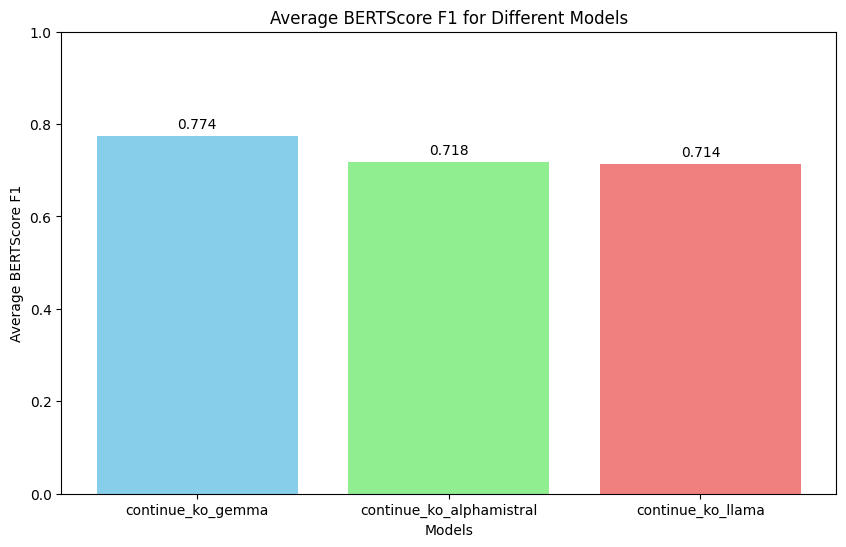

In [ ]:
models = ['continue_ko_gemma', 'continue_ko_alphamistral', 'continue_ko_llama']
scores = [0.7735405564308167, 0.717730700969696, 0.7137022018432617]

plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['skyblue', 'lightgreen', 'lightcoral'])

plt.title('Average BERTScore F1 for Different Models')
plt.xlabel('Models')
plt.ylabel('Average BERTScore F1')

plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

plt.show()